# Parallel Programming - Final Project: Autoencoder for CIFAR-10

Class: 22KHMT

Students: Group 6
| No. | StudentID | Name              |
| :-: | --------- | ----------------- |
|  1  | 22127008  | Đặng Châu Anh     |
|  2  | 22127170  | Trần Dịu Huyền    |
|  3  | 22127359  | Chu Thúy Quỳnh    |

---

## Section 0: Project Setup

First of all, extract the `src.zip` archive to retrieve the required source code for the project.

In [ ]:
!unzip -o src.zip

/bin/bash: line 1: unzip: command not found


---

## Section 1: Problem Description  

### 1. Problem Statement

This project focuses on building an image classification system for the CIFAR-10 dataset using a two-stage pipeline:
1. Unsupervised Feature Learning using a Convolutional Autoencoder
2. Supervised Classification using SVM trained on the learned features

Traditional supervised CNN training requires labeled data and tends to overfit when labels are limited. In contrast, an autoencoder learns meaningful representations without labels by reconstructing the input images.  
The encoder compresses each 32x32x3 image into an 8,192-dimensional latent vector that captures important visual patterns such as edges, textures, and shapes. These learned features are then used as inputs to an SVM classifier for the final prediction.

**Motivation for GPU Acceleration:**  
Training a convolutional autoencoder on 50,000 images involves:
- Many 3x3 convolutions
- Millions of multiply-accumulate operations per batch
- Repeated forward/backward passes over many epochs

On a CPU, this process can take hours. The primary objective of the project is to accelerate autoencoder training from hours on CPU to minutes on GPU using CUDA, through parallelization and a wide range of GPU optimization strategies

### 2. CIFAR-10 Dataset Overview


**Dataset specifications**
- Image size: 32x32 pixels (RGB)
- 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- Training set: 50,000 images (5,000 per class)
- Test set: 10,000 images (1,000 per class)
- Total images: 60,000
- Format: Binary files with uint8 pixel values

**Sample images**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Download
if not os.path.exists('data/cifar-10-batches-bin'):
    print("Downloading CIFAR-10...")
    !wget -q -P data https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
    !tar -xvf data/cifar-10-binary.tar.gz -C data/
    print("Dataset ready.")


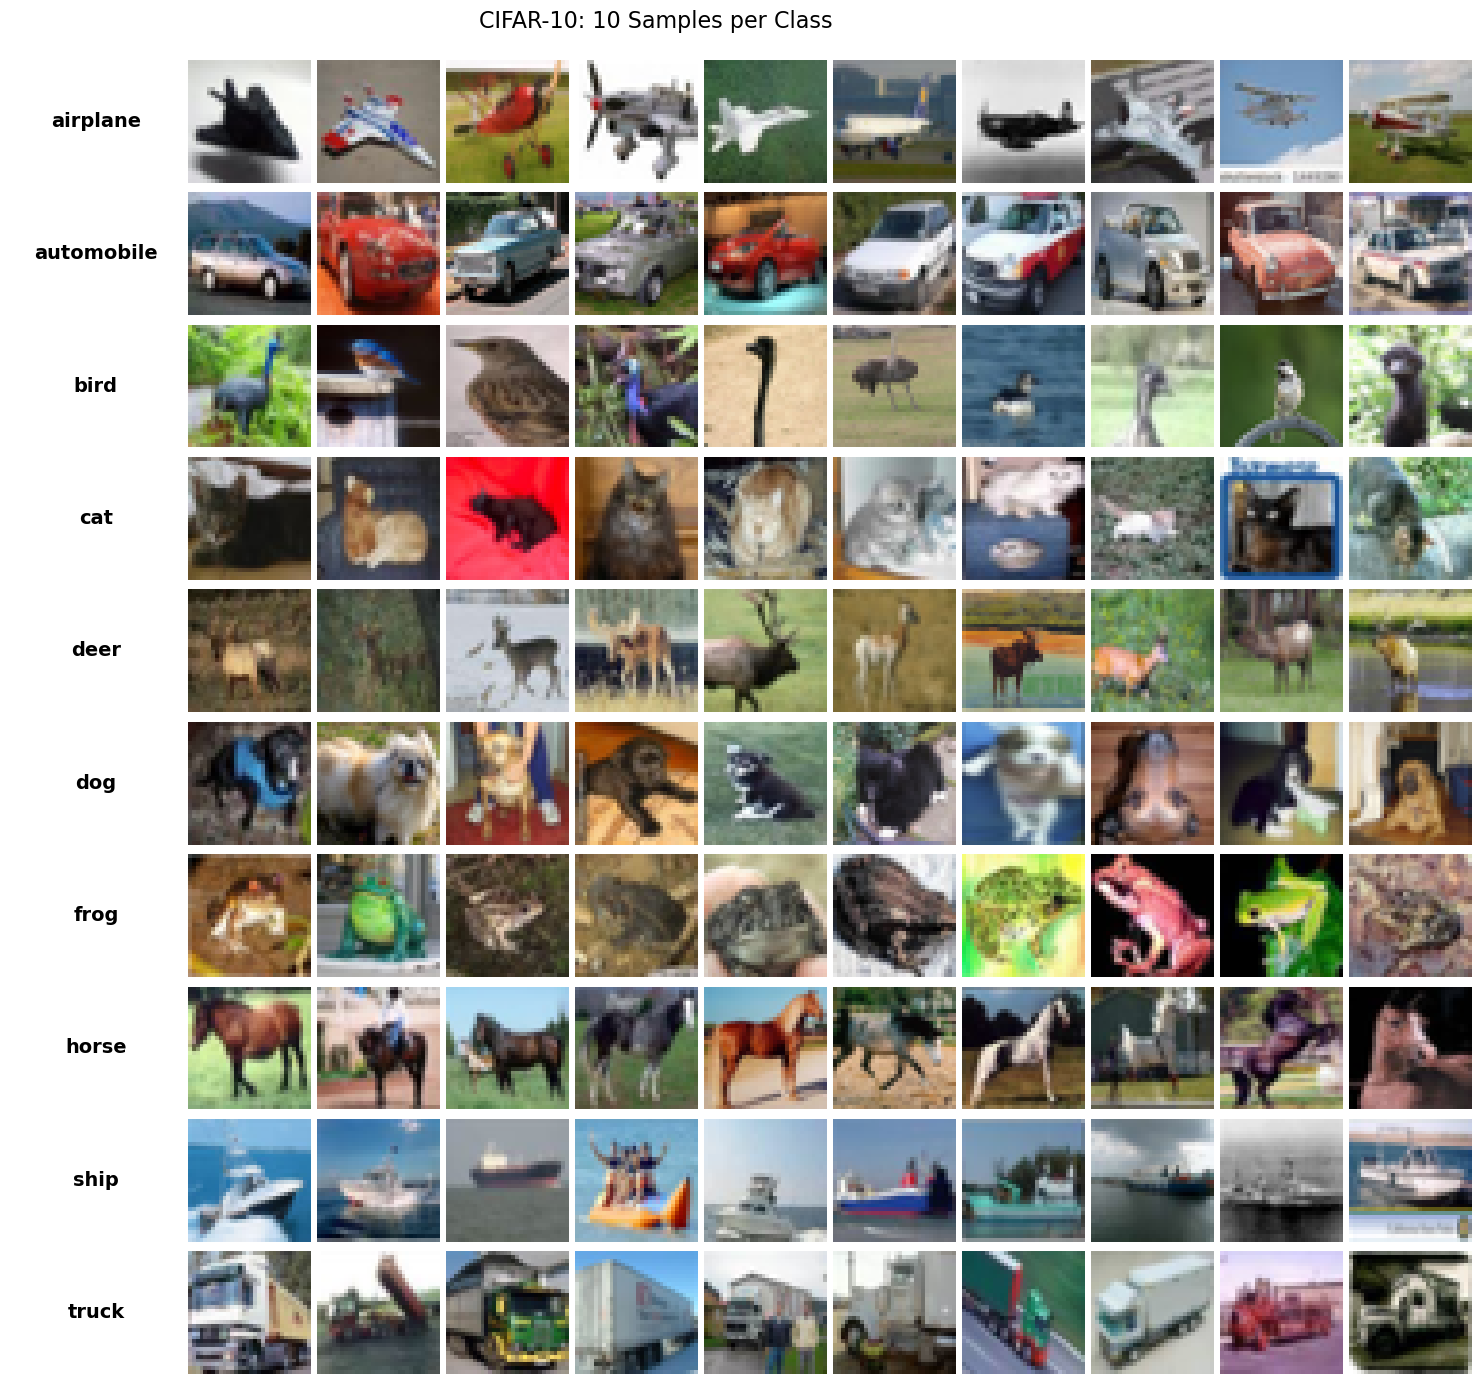

In [3]:
def show_samples_per_class():
    all_images, all_labels = [], []

    # Load 5 training batches
    for i in range(1, 6):
        path = f"data/cifar-10-batches-bin/data_batch_{i}.bin"
        with open(path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8)
        raw = data.reshape(-1, 3073)
        labels = raw[:, 0]
        images = raw[:, 1:].reshape(-1, 3, 32, 32).transpose(0,2,3,1)

        all_labels.append(labels)
        all_images.append(images)

    all_labels = np.concatenate(all_labels)
    all_images = np.concatenate(all_images)

    # Collect 10 samples per class
    samples = {c: [] for c in range(10)}
    for img, lbl in zip(all_images, all_labels):
        if len(samples[lbl]) < 10:
            samples[lbl].append(img)
        if all(len(samples[c]) == 10 for c in range(10)):
            break

    # Widen first column
    fig, axes = plt.subplots(
        10, 11,
        figsize=(17, 14),
        gridspec_kw={'width_ratios': [1.4] + [1]*10}
    )

    plt.subplots_adjust(wspace=0.05, hspace=0.06,
                        left=0.12, right=0.98, top=0.96, bottom=0.02)

    for cls in range(10):
        # Label column
        ax_label = axes[cls, 0]
        ax_label.axis("off")
        ax_label.text(
            0.5, 0.5,
            class_names[cls],
            ha='center', va='center',
            fontsize=14, fontweight='bold',
            transform=ax_label.transAxes
        )

        # images
        for j in range(10):
            ax = axes[cls, j+1]
            ax.imshow(samples[cls][j])
            ax.axis("off")

    fig.suptitle("CIFAR-10: 10 Samples per Class", fontsize=16, y=0.995)
    plt.show()


show_samples_per_class()

**Explain data preprocessing steps**
- Read CIFAR-10 binary files (5 training batches + 1 test batch).
- Parse the binary format: 1 byte label + 3,072 bytes image per record.
- Convert uint8 pixel values [0, 255] to float [0, 1] for normalization.
- Implement batch generation for training.
- Add data shuffling capability.
- Organize train images (50,000), test images (10,000), and their labels in memory.

### 3. Autoencoder Architecture


**Network architecture diagram**

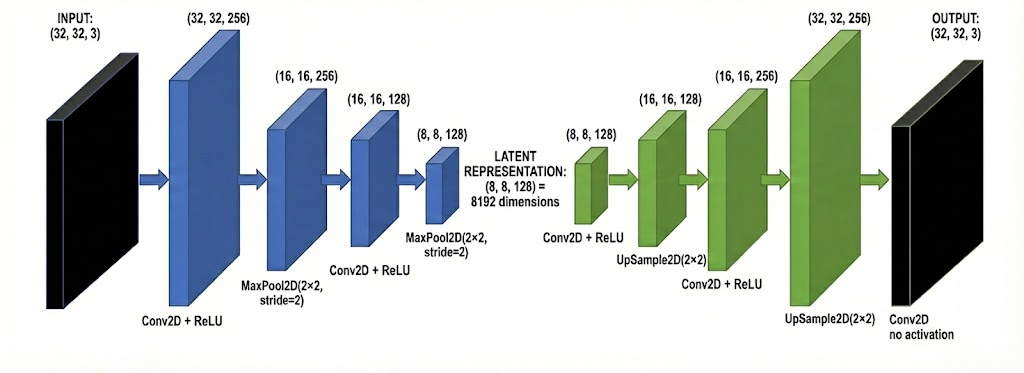

**Specify layer dimensions and transformations**

| Step | Operation                              |                                                               Params / Details | Output shape                       |
| ---- | -------------------------------------- | -----------------------------------------------------------------------------: | :--------------------------------- |
| 0    | Input image                            |                                                                      RGB image | **(32, 32, 3)**                    |
| 1    | Conv2D                                 |                  256 filters, 3x3 kernel, padding=1, stride=1, activation=ReLU | **(32, 32, 256)**                  |
| 2    | MaxPool2D                              |                                                        pool size 2x2, stride=2 | **(16, 16, 256)**                  |
| 3    | Conv2D                                 |                  128 filters, 3x3 kernel, padding=1, stride=1, activation=ReLU | **(16, 16, 128)**                  |
| 4    | MaxPool2D                              |                                                        pool size 2x2, stride=2 | **(8, 8, 128)**                    |
| _    | **Latent representation (bottleneck)** |                                                                              _ | **(8, 8, 128) = 8,192 dimensions** |
| 5    | Conv2D                                 |                  128 filters, 3x3 kernel, padding=1, stride=1, activation=ReLU | **(8, 8, 128)**                    |
| 6    | UpSampling2D                           |                                                scale 2x2 (nearest or bilinear) | **(16, 16, 128)**                  |
| 7    | Conv2D                                 |                  256 filters, 3x3 kernel, padding=1, stride=1, activation=ReLU | **(16, 16, 256)**                  |
| 8    | UpSampling2D                           |                                                                      scale 2x2 | **(32, 32, 256)**                  |
| 9    | Conv2D (output)                        |                      3 filters, 3x3 kernel, padding=1, stride=1, no activation | **(32, 32, 3)**                    |


**Explain the encoder-decoder structure and latent representation**

Encoder
- The encoder applies two stages of Conv2D -> ReLU -> MaxPool.
- The first convolution expands the channel dimension from 3 -> 256 while preserving spatial resolution (3x3, padding=1). MaxPool then halves spatial dimensions (32->16).
- The second stage reduces channels to 128 while further halving spatial size to 8x8.
- The encoder therefore compresses both spatial and channel information, producing a dense feature tensor (8, 8, 128) which is the latent representation.

Latent representation
- The tensor (8x8x128) is the information the encoder preserves for reconstruction/classification.
- Flattening would give 8192 values, but this design keeps the latent as a 3D tensor so the network remains fully convolutional (no fully-connected flattening required).
- The latent space encodes spatially local features and higher-level patterns useful for downstream tasks (here: SVM classification on extracted features).

Decoder
- The decoder mirrors the encoder: it first applies a Conv2D on the latent tensor (128 filters), then upsamples (x2) to restore spatial size, increases channels (to 256) with another convolution, upsamples again (x2), and finally projects back to 3 channels for RGB reconstruction.
- The final Conv2D uses no activation (identity) so the network can produce raw pixel values.

## 4. Project Objectives

### Performance Goals
| Metric                    | Target                              |
| ------------------------- | ----------------------------------- |
| Autoencoder training time | < 10 minutes                        |
| Feature extraction time   | < 20 seconds cho toàn bộ 60.000 ảnh |
| Test accuracy (SVM)       | 60–65%                              |
| GPU speedup over CPU      | >20x                                |


### Technical learning objectives
- Implementing a convolutional autoencoder on CPU.
- Implementing and optimizing GPU kernels using CUDA.
- Managing GPU memory efficiently (global, shared, constant memory).
- Applying optimization strategies such as tiling, kernel fusion, vectorization.
- Using SVM (LIBSVM) for classification.
- Profiling and performance analysis.

### Success criteria
- The autoencoder reconstructs images correctly.
- GPU training is at least x faster than CPU baseline.
- Feature extraction produces correct 8,192-dim vectors.
- SVM achieves ≥ 60% accuracy on CIFAR-10.
- The final report includes full analysis, visualizations, and performance metrics.

---

## Section 2: Implementation Phases

### Phase 2.1: CPU Baseline Implementation



**1. Objectives**

**2. Implementation Details**







* Data Pipeline

* Layer Implementation (CPU)

Key Code Snippet: Convolution Layer (Header)

In [4]:
!cat src/phase1/cpu_layers.h | grep -A 10 "class Conv2D"

class Conv2D {
public:
    int in_c, out_c, k_size, stride, pad;
    vector<float> weights, biases;
    vector<float> grad_w, grad_b;
    Tensor input_cache;

    Conv2D(int in, int out, int k=3, int s=1, int p=1);
    void init_weights();
    Tensor forward(const Tensor& input);
    Tensor backward(const Tensor& grad_out, float lr);


- Training Loop

**3. Execution & Results**

In [5]:
!g++ -O3 -I./src \
    src/phase1/*.cpp \
    src/*.cpp \
    -o run_phase1

/bin/bash: line 1: g++: command not found


In [6]:
!./run_phase1

/bin/bash: line 1: ./run_phase1: No such file or directory
